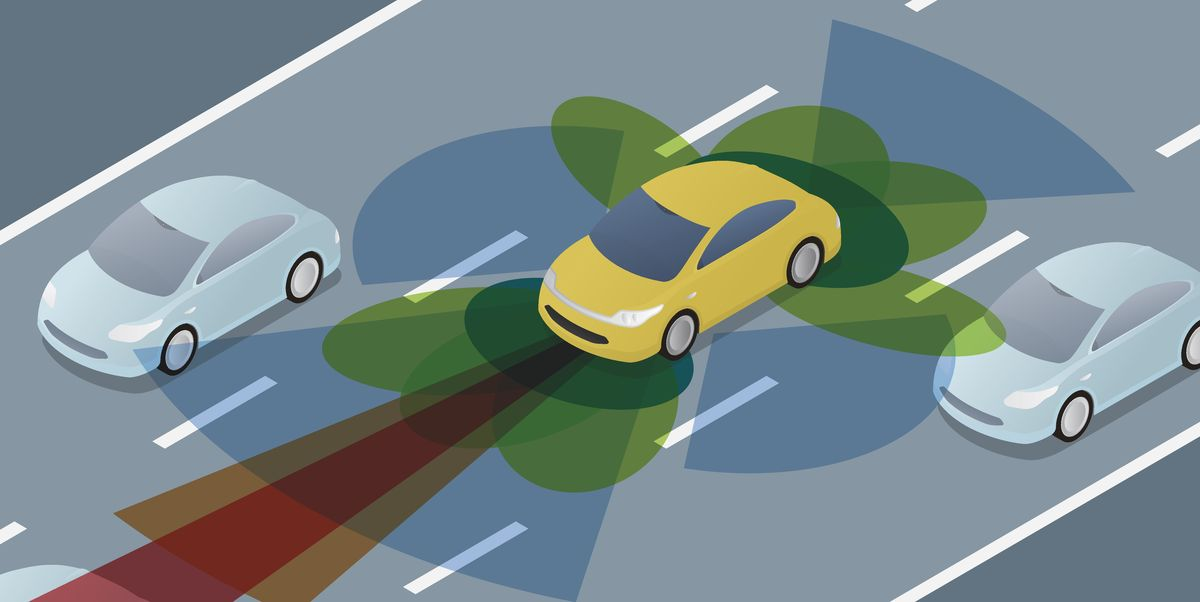

# What is an Autonomous Car?
 **An autonomous car is a vehicle capable of sensing its environment and operating without human involvement. A human passenger is not required to take control of the vehicle at any time, nor is a human passenger required to be present in the vehicle at all. An autonomous car can go anywhere a traditional car goes and do everything that an experienced human driver does.The Society of Automotive Engineers (SAE) currently defines 6 levels of driving automation ranging from Level 0 (fully manual) to Level 5 (fully autonomous). These levels have been adopted by the U.S. Department**

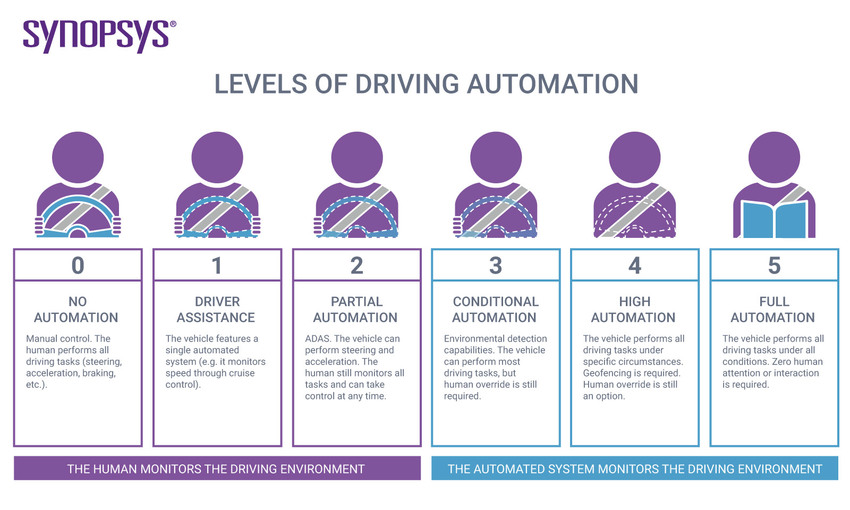

# Lidars
The spinning thing you see on top of most self-driving cars is lidar (that’s “light detection and ranging”). It fires out millions of laser beams every second, measures how long they take to bounce back, and uses the data to build a 3D map that’s more precise than what radar offers and easier for a computer to understand than a 2D camera image. It’s also crazy expensive, hard to manufacture at scale, and nowhere near robust enough for a life of potholes and extreme temperatures. Good thing dozens of startups and tech giants are pouring millions of dollars into fixing all that.

# Cameras
Great for spotting things like lane lines on the highway, speed signs, and traffic lights. Some developers think that, with better machine vision, they can use cameras to identify everything they see and navigate accordingly.

# Machine Learning
At its simplest, this artificial intelligence tool trains computers to do things like detect lane lines and identify cyclists by showing them millions of examples of the subject at hand. Because the world is too complex to write a rule for every possible scenario, it’s key to have cars that can learn from experience and figure out how to navigate on their own.

# Maps
Before a robocar takes to the streets, its parent company will use cameras and lidars to map its territory in extreme detail. That reference document helps the car verify its sensor readings, and it is key for any vehicle looking to know its own location, down to the centimeter—something standard GPS can’t offer.

# Radars
A regular presence in cars since the late 1990s, radars bounce radio waves around to see their surrounding and are especially good at spotting big metallic objects—other vehicles. They’re cheap, reliable, and don’t sweat things like fog, rain, or snow.

# Stanford Cart
**The first ever self driving car in history, built in 1961**

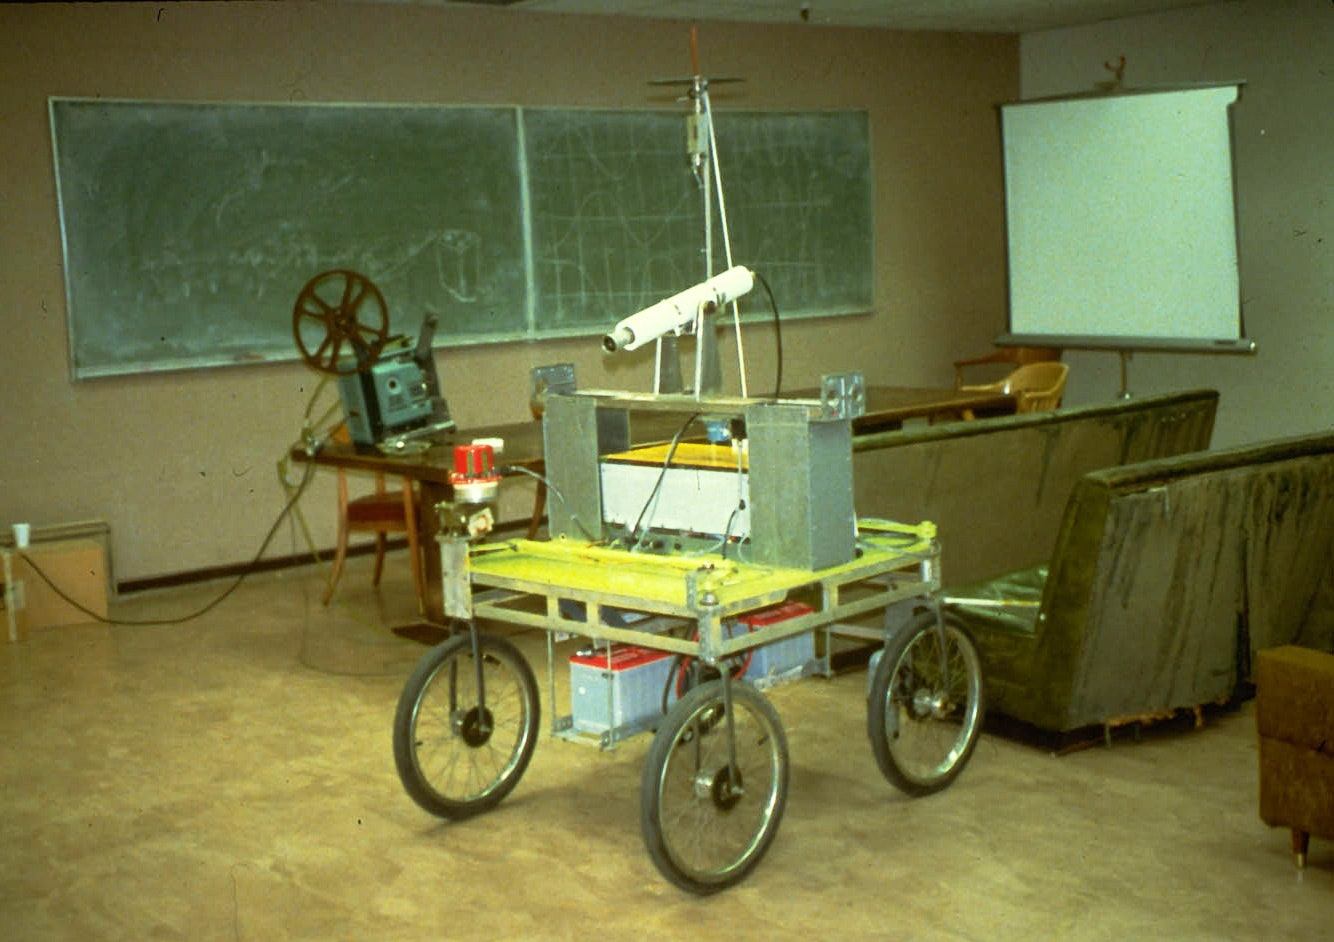

[Tesla Auto Pilot](https://www.youtube.com/watch?v=tlThdr3O5Qo)

In [ ]:
!pip install --upgrade pip
!pip install pymap3d==2.1.0
!pip install -U l5kit

In [ ]:
import os
import numpy as np
import pandas as pd
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from l5kit.data import PERCEPTION_LABELS
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib import animation, rc
from matplotlib.ticker import MultipleLocator
from IPython.display import display, clear_output
import PIL
from IPython.display import HTML

rc('animation', html='jshtml')

**Configuring the environment**

In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"
cfg = load_config_data("/kaggle/input/lyft-config-files/visualisation_config.yaml")
print(cfg)

# Load the Data

In [ ]:
# local data manager
dm = LocalDataManager()
# set dataset path
dataset_path = dm.require(cfg["val_data_loader"]["key"])
# load the dataset; this is a zarr format, chunked dataset
chunked_dataset = ChunkedDataset(dataset_path)
# open the dataset
chunked_dataset.open()
print(chunked_dataset)

# Data exploration

In [ ]:
agents = chunked_dataset.agents
agents_df = pd.DataFrame(agents)
agents_df.columns = ["data"]; features = ['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities']

for i, feature in enumerate(features):
    agents_df[feature] = agents_df['data'].apply(lambda x: x[i])
agents_df.drop(columns=["data"],inplace=True)
print(f"agents dataset: {agents_df.shape}")
agents_df.head()

# Centroid distrbution

In [ ]:
agents_df['cx'] = agents_df['centroid'].apply(lambda x: x[0])
agents_df['cy'] = agents_df['centroid'].apply(lambda x: x[1])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plt.scatter(agents_df['cx'], agents_df['cy'], marker='+')
plt.xlabel('x', fontsize=11); plt.ylabel('y', fontsize=11)
plt.title("Centroids distribution")
plt.show()

In [ ]:
multi_mode = pd.read_csv("../input/lyft-motion-prediction-autonomous-vehicles/multi_mode_sample_submission.csv")

In [ ]:
multi_mode.describe

In [ ]:
multi_mode.head()

In [ ]:
multi_mode.shape

> Sample path

In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager()
sample_path = '../input/lyft-motion-prediction-autonomous-vehicles/scenes/sample.zarr'
sample_dataset = ChunkedDataset(sample_path)
sample_dataset.open()
print(sample_dataset)

In [ ]:
sample_agents = sample_dataset.agents
sample_agents = pd.DataFrame(sample_agents)
sample_agents.columns = ["data"]; features = ['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities']

for i, feature in enumerate(features):
    sample_agents[feature] = sample_agents['data'].apply(lambda x: x[i])
sample_agents.drop(columns=["data"],inplace=True)
sample_agents.head()

Test Path

In [ ]:
test_path = '../input/lyft-motion-prediction-autonomous-vehicles/scenes/test.zarr'
test_dataset = ChunkedDataset(test_path)
test_dataset.open()
print(test_dataset)

**Train Path**

In [ ]:
train_path = '../input/lyft-motion-prediction-autonomous-vehicles/scenes/train.zarr'
train_dataset = ChunkedDataset(train_path)
train_dataset.open()
print(train_dataset)

Validation path

In [ ]:
valid_path = '../input/lyft-motion-prediction-autonomous-vehicles/scenes/validate.zarr'
valid_dataset = ChunkedDataset(valid_path)
valid_dataset.open()
print(valid_dataset)

Semantic View of the road map

In [ ]:
cfg = {}
raster_params = {'raster_size':[512,512],
                 'pixel_size':[0.5,0.5],
                 'ego_center':[0.25,0.5],
                 'map_type':'py_semantic',
                 'satellite_map_key': 'aerial_map/aerial_map.png',
                 'semantic_map_key': 'semantic_map/semantic_map.pb',
                 'dataset_meta_key': 'meta.json',
                 'filter_agents_threshold': 0.5}
model_params ={'model_architecture': 'effnetB5',
               'history_num_frames': 0,
               'history_step_size': 1,
               'history_delta_time': 0.1,
               'future_num_frames': 50,
               'future_step_size': 1,
               'future_delta_time': 0.1}
cfg['raster_params'] = raster_params
cfg['model_params'] = model_params
rast = build_rasterizer(cfg,dm)
dataset = EgoDataset(cfg, test_dataset, rast)
scene_idx = 2
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))

Satellite View of the road

In [ ]:
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, sample_dataset, rast)
scene_idx = 2
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))

**Aerial Map of the road**

In [ ]:
import cv2
image = cv2.imread('../input/lyft-motion-prediction-autonomous-vehicles/aerial_map/aerial_map.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(32,32))
plt.imshow(image)

References - 

https://www.kaggle.com/gpreda/lyft-first-data-exploration

https://www.kaggle.com/vineeth1999/lyft-motion-prediction-eda

https://www.wired.com/story/guide-self-driving-cars/
